In [1]:
import plotly.express as px
import numpy as np

from sklearn.decomposition import PCA

In [2]:
from neo4j import GraphDatabase
from tqdm.notebook import tqdm
import json

import pandas as pd

In [3]:
auth_path = './data/neo4j_graph/auth.json'
with open(auth_path, 'r') as f:
    auth = json.load(f)

# ローカルの場合は通常 uri: bolt(or neo4j)://localhost:7687, user: neo4j, pd: 設定したもの
# サンドボックスの場合は作成画面から接続情報が見られます
uri = 'neo4j://localhost:7687'
driver = GraphDatabase.driver(uri=uri, auth=(auth['user'], auth['pd']))

# Sandboxの場合はこんな感じ
# uri = 'bolt://54.175.38.249:35275'
# driver = GraphDatabase.driver(uri=uri, auth=('neo4j', 'spray-missile-sizing'))

In [4]:
with driver.session() as session:
    country_list = session.run('''
    MATCH (c:Country)
    WHERE exists(c.vector_epoch1) AND exists(c.vector_epoch2) AND exists(c.vector_epoch3)
    RETURN c.name as name
    ''')

In [5]:
country_list = pd.DataFrame([r.data() for r in country_list])

In [6]:
country_list

,name
0,Australia
1,Austria
2,Belgium
3,Cambodia
4,Canada
...,...
59,United Arab Emirates
60,United Kingdom
61,United States
62,Uruguay


In [7]:
country_name = 'Australia'

In [8]:
with driver.session() as session:
    country_vecs = session.run('''
    MATCH (c:Country {name: $country_name})-[r:TRANSFERRED_COUNTRY_SEPARATE]-(c_around)
    WHERE c_around.name in $country_list
    RETURN c_around.name as name, c_around.vector_epoch1 as vec1, c_around.vector_epoch2 as vec2, c_around.vector_epoch3 as vec3, count(r) AS transaction_count ORDER BY transaction_count DESC　LIMIT 15
    ''', country_name=country_name, country_list=country_list['name'].to_list())
    
country_vecs_list = [c.data() for c in country_vecs]
    
with driver.session() as session:
    country_vec = session.run('''
    MATCH (c:Country {name: $country_name})
    RETURN c.name as name, c.vector_epoch1 as vec1, c.vector_epoch2 as vec2, c.vector_epoch3 as vec3
    ''', country_name=country_name, country_list=country_list['name'].to_list())

country_vecs_list += [c.data() for c in country_vec]
country_vecs = pd.DataFrame(country_vecs_list)

In [9]:
vec_texts = {
    1: 'Russia era: ~2011',
    2: 'Singapore era: 2012~2014',
    3: 'Latvia era: 2015~'
}

Russia era: ~2011


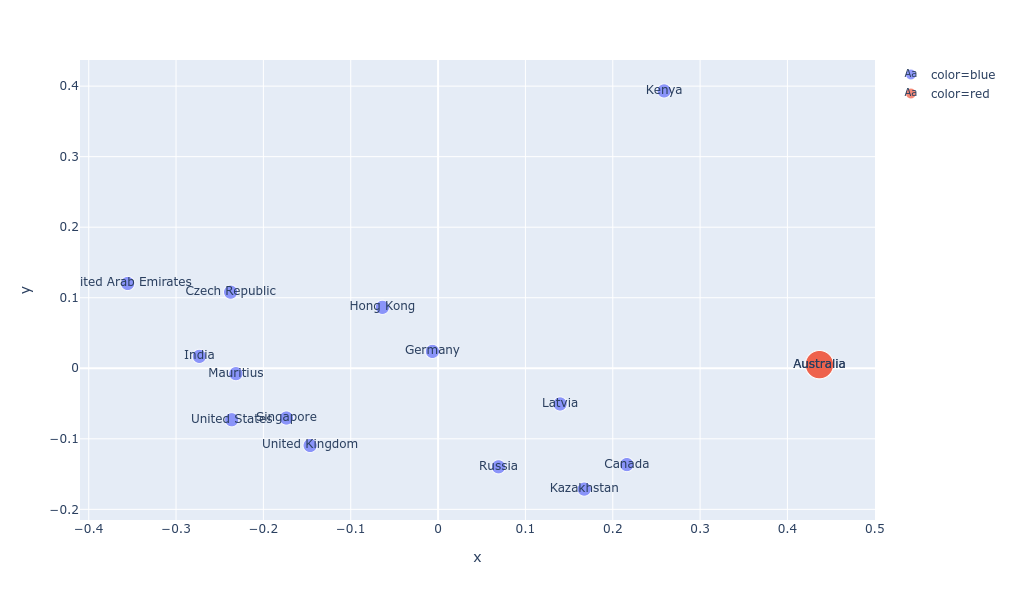

Singapore era: 2012~2014


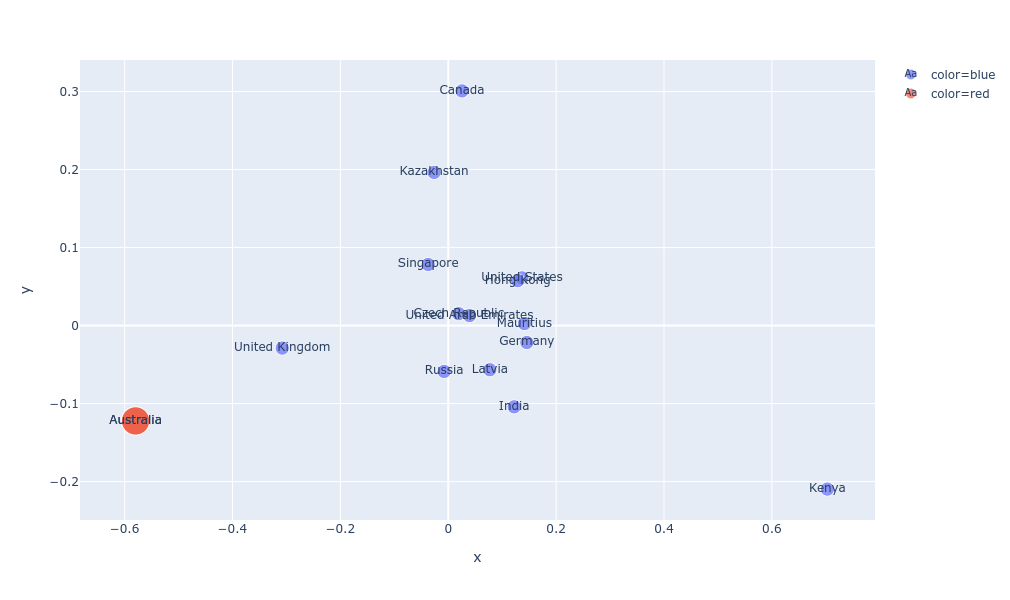

Latvia era: 2015~


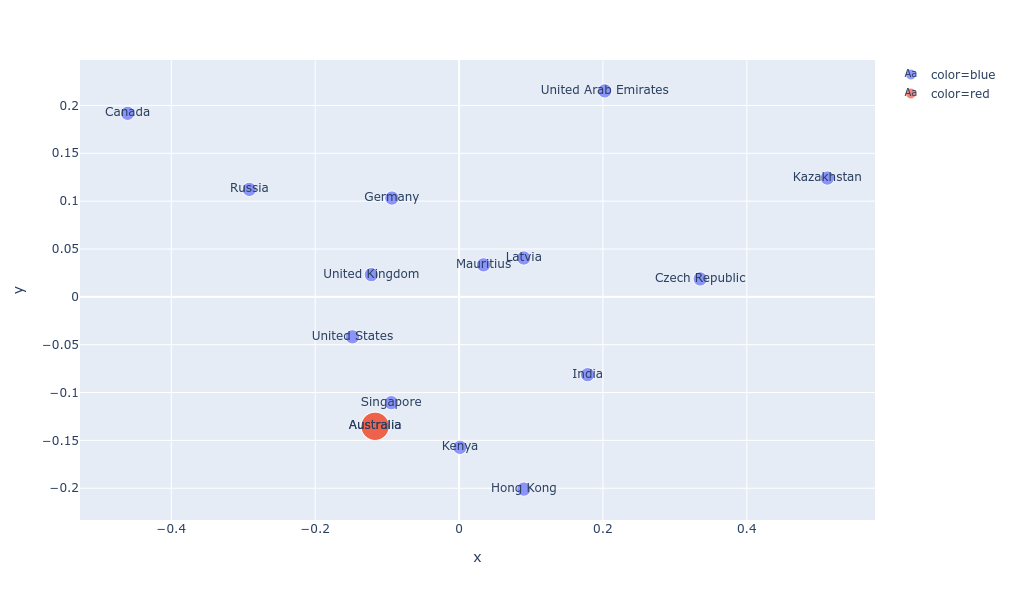

In [13]:
pca = PCA(n_components=2)

for vec_type_id in range(1, 4):
    vec_type = 'vec{}'.format(vec_type_id)
    
    vec = country_vecs[vec_type].to_list()
    vec = np.array(vec)
    vec_renorm = vec / np.sqrt((vec ** 2).sum(axis=1).reshape(-1, 1))
    vec_pca = pca.fit_transform(vec_renorm)
    
    fig_vec = px.scatter(x=vec_pca[:, 0],
                         y=vec_pca[:, 1],
                         text=country_vecs['name'],
                         color=country_vecs['name'].apply(lambda x: {True: 'red', False: 'blue'}[x==country_name]),
                         size=country_vecs['name'].apply(lambda x: {True: 20, False: 5}[x==country_name])
                         )
    print(vec_texts[vec_type_id])
    fig_vec.show()

In [28]:
with driver.session() as session:
    transaction_count = session.run('''
    MATCH (c:Country {name:$country_name})-[r:TRANSFERRED_COUNTRY_SEPARATE]-()
    RETURN r.begin.year AS year, count(r) AS transaction_count ORDER BY year 
    ''', country_name=country_name)

transaction_count = pd.DataFrame([r.data() for r in transaction_count])

transaction_count

,year,transaction_count
0,2011,1
1,2012,81
2,2013,1
3,2014,10
4,2015,15
5,2016,12


In [30]:
fig = px.line(transaction_count, x='year', y='transaction_count')